
> # **Pins Face Recognition**


> **Facial Recognition Dataset collected from Pinterest**

>[https://www.kaggle.com/hereisburak/pins-face-recognition](https://)

**Dataset Content:**

>This images has been collected from Pinterest and cropped. There are 105 celebrities and 17534 faces.

**Description:**
>The below Python code will unzip the above downloaded dataset by the user and split it into the training set and and validation set based on the given ratio.**Transfer Learning** has been implemented  with the **MobileNetV2** model and **imagenet** weights. The pre-trained model consists of 155 layers and the whole layers of the pretrained model is retrained to get the better accuracy.Image Augmentation has been implemented to avoid the overfitting of the model.
The model has been trained for the 50 epochs and the **Validation Accuracy of 85%** has been yielded.Note:The model performs well on the cropped images.





In [20]:
# Move the downloaded the zipfile of dataset into the current working directory or modify the path in the code to the location of the downloaded dataset.
import os
from zipfile import ZipFile
work_dir = os.getcwd()                                                  #Saves the current working directory.
with ZipFile(os.path.join(work_dir ,'pins-face-recognition.zip'),'r') as zipobject:
  zipobject.extractall()                                                #Unzip the downloaded dataset.s

In [21]:
train_dir = os.path.join(work_dir,'train')       #Path of train directory. 
test_dir = os.path.join(work_dir,'test')         #Path of test directory.
os.makedirs(train_dir, exist_ok=True)  #Creating a directory for training examples. 
os.makedirs(test_dir, exist_ok=True)   #Creating a directory for testing examples. 

In [22]:
train_ratio=0.8
test_ratio=0.2
dir_list=os.listdir(os.path.join(work_dir ,'105_classes_pins_dataset'))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

The Number of Classes in the Dataset is:105


In [28]:
#This Code will split up the unzipped dataset into training and testing set with respect to the values of train_ratio and test_ratio.
from shutil import copyfile
import numpy as np

source_dir = os.path.join(work_dir ,'105_classes_pins_dataset')        #Unzipped dataset directory 

dir_list = os.listdir(source_dir)

for folder in dir_list:
    data_dir = os.listdir(os.path.join(source_dir,folder))
    np.random.shuffle(data_dir)                            #Shuffling the examples of the classes inside the dataset.
    os.makedirs(os.path.join(train_dir , folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir , folder), exist_ok=True)
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)] #Splitting the training dataset with respect to the train_ratio.
    test_data = data_dir[-int(len(data_dir)*test_ratio):]
  
    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image)) #Copying the Training files from dataset to training directory.
    
    for image in test_data:
       copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image))  #Copying the Training files from dataset to training directory.
    

In [30]:

print("The Number of Classes in the Training Set:{}".format(len(os.listdir(train_dir))))
print("The Number Of Classes in the Testing Set:{}".format(len(os.listdir(test_dir))))
print('For Verification of the Split.....')
print("The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:{}".format(len(os.listdir(os.path.join(source_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:{}".format(len(os.listdir(os.path.join(train_dir,'pins_Katherine Langford')))))
print("The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:{}".format(len(os.listdir(os.path.join(test_dir,'pins_Katherine Langford')))))


The Number of Classes in the Training Set:105
The Number Of Classes in the Testing Set:105
For Verification of the Split.....
The Number of Examples in the Class='pins_Katherine Langford' in the Dataset Directory:226
The Number of Examples in the Class='pins_Katherine Langford' in the Train Directory:181
The Number of Examples in the Class='pins_Katherine Langford' in the Test Directory:45


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=160  #Number of Pixels in the Rows for Input. 
cols=160  #Number of Pixels in Columns for Output

In [ ]:
trained_model=MobileNetV2(input_shape=(rows,cols,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [ ]:
#Callback Function which stops training when accuracy reaches 98%.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(rows,cols),
                                                class_mode='categorical')

Found 14084 images belonging to 105 classes.
Found 3463 images belonging to 105 classes.


In [ ]:
result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=50,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/50
441/441 [==============================] - 113s 257ms/step - loss: 4.9971 - accuracy: 0.0153 - val_loss: 4.8716 - val_accuracy: 0.0248
Epoch 2/50
441/441 [==============================] - 111s 252ms/step - loss: 4.5391 - accuracy: 0.0258 - val_loss: 4.4199 - val_accuracy: 0.0393
Epoch 3/50
441/441 [==============================] - 111s 251ms/step - loss: 4.2396 - accuracy: 0.0552 - val_loss: 4.0829 - val_accuracy: 0.0745
Epoch 4/50
441/441 [==============================] - 110s 250ms/step - loss: 3.8009 - accuracy: 0.1065 - val_loss: 3.3910 - val_accuracy: 0.1741
Epoch 5/50
441/441 [==============================] - 110s 249ms/step - loss: 3.3586 - accuracy: 0.1795 - val_loss: 2.8764 - val_accuracy: 0.2616
Epoch 6/50
441/441 [==============================] - 110s 250ms/step - loss: 2.9315 - accuracy: 0.2609 - val_loss: 2.5329 - val_accuracy: 0.3624
Epoch 7/50
441/441 [==============================] - 110s 250ms/step - loss: 2.5319 - accuracy: 0.3469 - val_loss: 2.3861 -

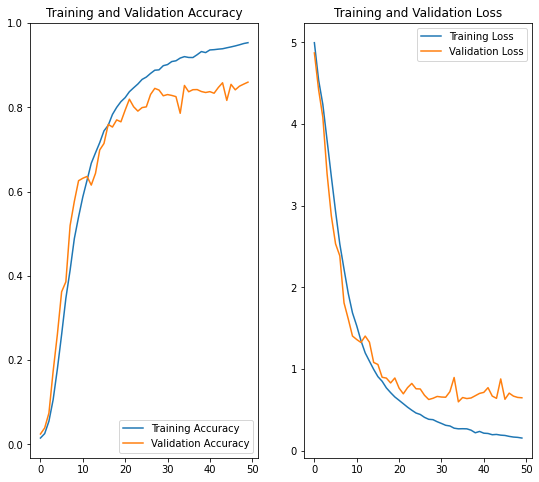

In [ ]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path="/images (8).jpg"  #Path to the target image to be predicted. 

classes=train_generator.class_indices
class_names=list(classes.keys())   #List of the class names
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(rows, cols)
)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.

score = model.predict(img_array)

print(
    "The Person in the Image is {} ."
    .format(class_names[np.argmax(score)][5:].title())
)

The Person in the Image is Robert Downey Jr .
